<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Exercise_Model_selection_Titanic_dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Exercise:** `Model Selection`
---

**study case: dataset 'titanic.csv'**

**Target: 'alive'**

**Preprocessing scheme:**
* Drop feature 'deck'
* Fill missing value 'age' with simple imputed median
* Fill missing value 'embark town' with simple imputed modus
* One-hot encoding: 'sex', 'embark town', 'alone'
* Ordinal encoding: 'class'
* Scaling with RobustScaler()

**Model building**
- Split data 80:20 with random_state = 0.
- Use the accuracy score metric.
- Select the best model with cross-validation (n_splits=5):
* Logistic regression: solver = liblinear
* KNN: n_neighbors = 3
* Decision tree: max depth = 3

**Hyperparameter tuning**
- Tune the best model.

### **Initial Setup**

In [54]:
# Additional Initial setup
# !pip install category_encoders

In [3]:
# Importing required libraries

# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Splitting
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# ML algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# warnings
import warnings
warnings.filterwarnings('ignore')

# 'ggplot'
plt.style.use('ggplot')

## **Data Understanding**

- The dataset describes 891 individuals.
- Each row represents information/characteristics of the individual, such as age, gender, class, and other information, along with survivability information.

In [5]:
# Loading dataset
url = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/titanic.csv'
data = pd.read_csv(url)
data.head()


,sex,age,parch,fare,class,deck,embark_town,alive,alone
0,male,22.0,0,7.2500,Third,NaN,Southampton,no,False
1,female,38.0,0,71.2833,First,C,Cherbourg,yes,False
2,female,26.0,0,7.9250,Third,NaN,Southampton,yes,True
3,female,35.0,0,53.1000,First,C,Southampton,yes,False
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True


**Attribute Information**

| Attribute | Data Type | Description |
| --- | --- | --- |
|age | Integer | Age |
|workclass |Text | Working class |
|education.num | Integer | Education level |
|marital.status |Text | Marital status |
|occupation |Text | Type of employment |
|relationship |Text | Family status |
|race |Text | Ethnicity |
|sex |Text | Gender |
|capital.gain |Integer | Investment gain |
|capital.loss |Integer | Investment loss |
|hours.per.week |Integer | Hours worked per week |
|native.country |Text | Country of origin |
|income |Text | Income category |

**Initial Assesment**

In [6]:
# Check data type, null values, and unique values ​​of each column
pd.DataFrame({
    'feature': data.columns.values,
    'data_type': data.dtypes.values,
    'null': data.isna().mean().values * 100,
    'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
    'n_unique': data.nunique().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,null,negative,n_unique,sample_unique
0,sex,object,0.000000,False,2,"[male, female]"
1,age,float64,19.865320,False,88,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,..."
2,parch,int64,0.000000,False,7,"[0, 1, 2, 5, 3, 4, 6]"
3,fare,float64,0.000000,False,248,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51...."
4,class,object,0.000000,False,3,"[Third, First, Second]"
5,deck,object,77.216611,False,7,"[nan, C, E, G, D, A, B, F]"
6,embark_town,object,0.224467,False,3,"[Southampton, Cherbourg, Queenstown, nan]"
7,alive,object,0.000000,False,2,"[no, yes]"
8,alone,bool,0.000000,False,2,"[False, True]"


In [7]:
data['alone'] = data['alone'].astype(str)

**Descriptive Statistics**

In [8]:
display(data.describe(), data.describe(include='object'))

,age,parch,fare
count,714.000000,891.000000,891.000000
mean,29.699118,0.381594,32.204208
std,14.526497,0.806057,49.693429
min,0.420000,0.000000,0.000000
25%,20.125000,0.000000,7.910400
50%,28.000000,0.000000,14.454200
75%,38.000000,0.000000,31.000000
max,80.000000,6.000000,512.329200


,sex,class,deck,embark_town,alive,alone
count,891,891,203,889,891,891
unique,2,3,7,3,2,2
top,male,Third,C,Southampton,no,True
freq,577,491,59,644,549,537


### **Exploratory Data Analysis (EDA)**

#### `Numerical Features`

**Data Distribution**

In [9]:
numerical = [var for var in data.columns if data[var].dtypes not in ['object', 'bool']]

In [10]:
# Data distribution # Normal test
from scipy.stats import normaltest

dist = []

for i in range(len(numerical)):
    feature_name = numerical[i]
    stat, p_value = normaltest(data[feature_name].dropna())

    if p_value > 0.05:
        distribution = "Normally Distributed"
    else:
        distribution = "Not Normally Distributed"

    dist.append([feature_name, stat, p_value, distribution])

dist_df = pd.DataFrame(dist, columns=['Feature', "D'Agostino-Pearson Statistic", 'P-value', 'Distributed'])
dist_df

,Feature,D'Agostino-Pearson Statistic,P-value,Distributed
0,age,18.105033,1.170960e-04,Not Normally Distributed
1,parch,543.035282,1.206110e-118,Not Normally Distributed
2,fare,904.587271,3.727091e-197,Not Normally Distributed


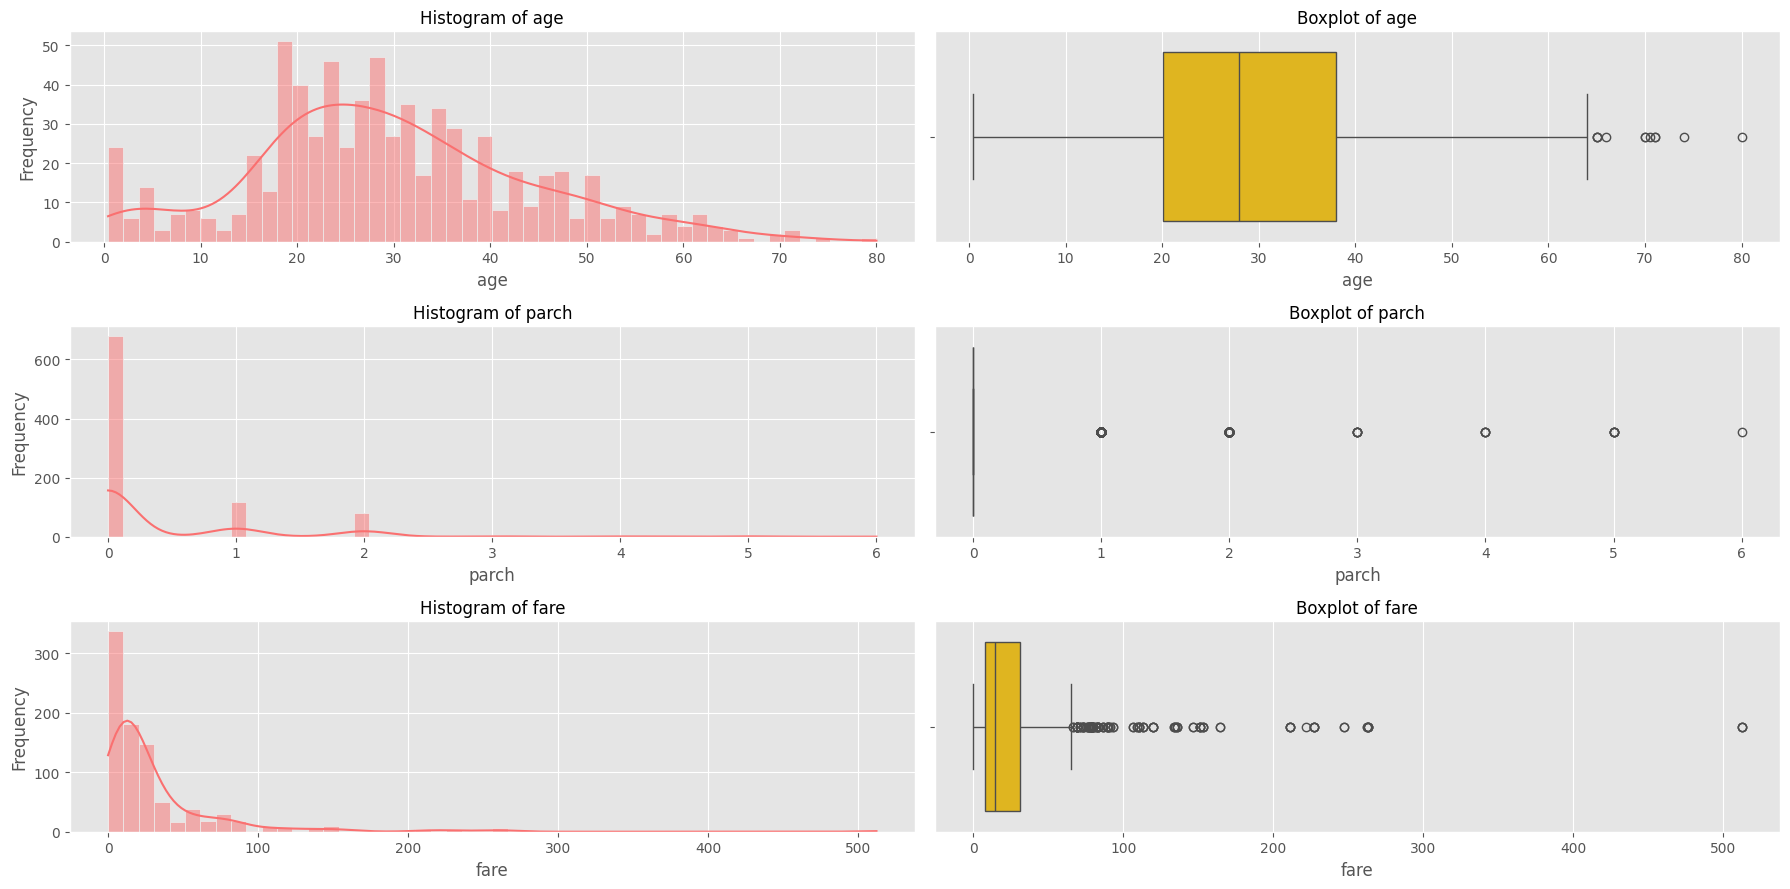

In [11]:
# Data distribution # visual
plt.figure(figsize=(18, 9))

for index, col in enumerate(numerical):
    # Histogram
    plt.subplot(len(numerical), 2, index * 2 + 1)
    sns.histplot(data[col], kde=True, color='#FA7070', bins=50)
    plt.title(f'Histogram of {col}', size=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(len(numerical), 2, index * 2 + 2)
    sns.boxplot(x=data[col], color='#FFC700')
    plt.title(f'Boxplot of {col}', size=12)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

**Correlation**

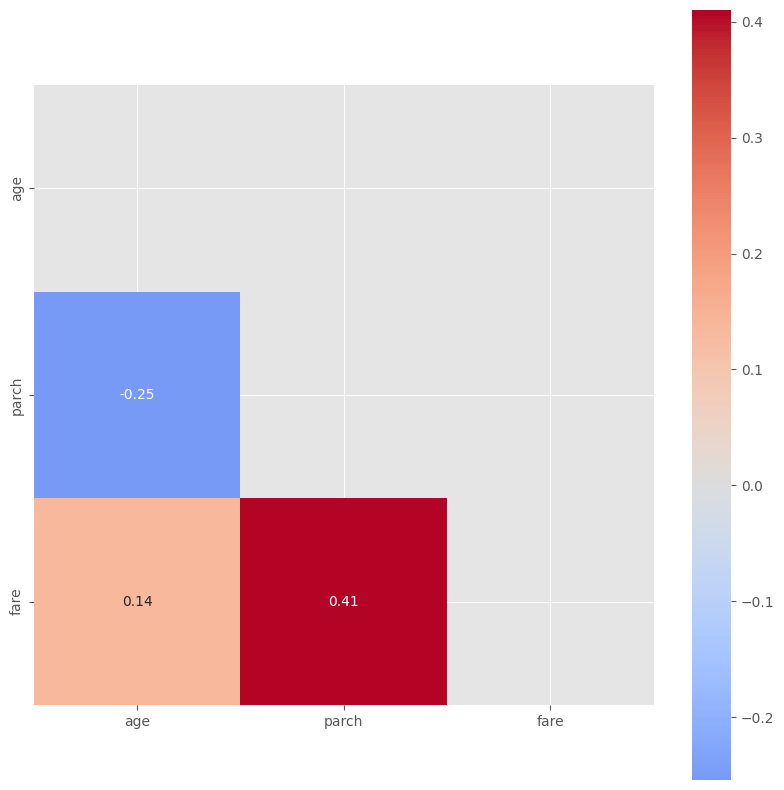

In [13]:
plt.figure(figsize=(10,10))

matrix = np.triu(data.select_dtypes(['int','float' ]).corr(method='spearman'))

sns.heatmap(data=data.select_dtypes(['int','float' ]).corr(method='spearman'), annot=True, cmap='coolwarm', center=0, mask = matrix, square='True')
plt.show()


**Feature vs Target**

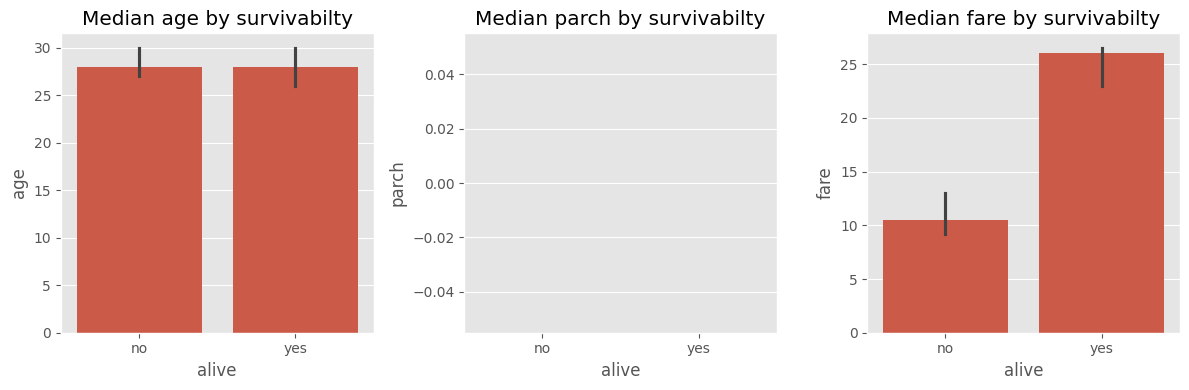

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

for col, j in zip(numerical, axes.flatten()):
    ax = sns.barplot(data=data, y= col, x='alive', estimator=np.median, ax= j)
    ax.set_title(f'Median {col} by survivabilty')

plt.tight_layout()
plt.show()

#### `Categorical Features`

**Distribution**

In [16]:
categorical = [var for var in data.drop(columns='alive').columns if data[var].dtypes in ['object', 'bool']]

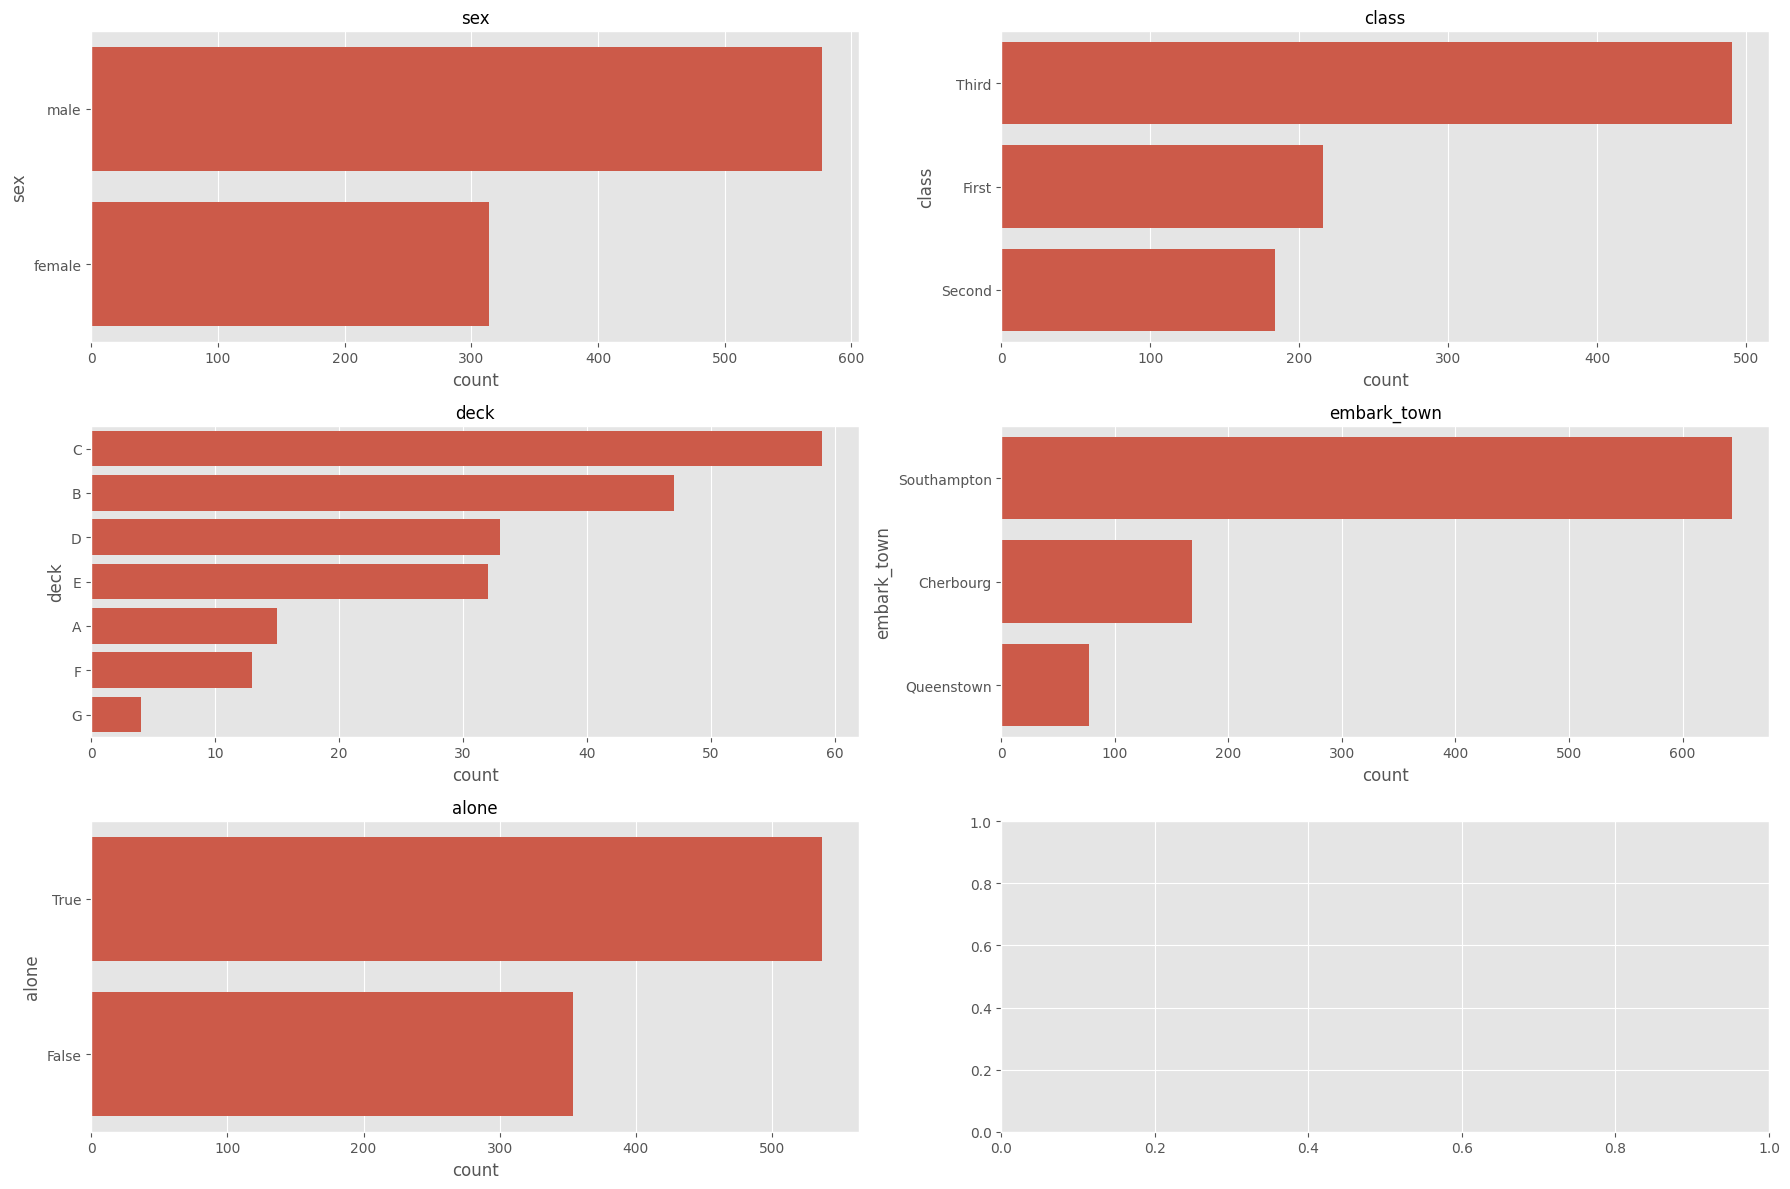

In [17]:
# Categorical data distribution
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
for i, j in zip(categorical, axes.flatten()):
    ax = sns.countplot(data=data, y= i, ax= j, order=data[i].value_counts().index)
    ax.set_title(f'{i}', size = 12)

plt.tight_layout()
plt.show()

**Feature vs Target**

In [18]:
def create_plot(data, col, x_maks=1000):

    agg_table = data.groupby([col, 'alive']).size().unstack().reset_index()
    agg_table['total'] = agg_table['yes']+agg_table['no']
    agg_table['% alive'] = (agg_table['yes']/agg_table['total']*100).round(2)
    agg_table = agg_table.sort_values(by='% alive', ascending=False)
    agg_table

    fig, axes = plt.subplots(1, 2, figsize=(16,5))

    ax1 = sns.barplot(data=agg_table, y=col, x='% alive', ax=axes[0])
    label = ['{:.1f} %'.format(x) for x in ax1.containers[0].datavalues]
    ax1.bar_label(ax1.containers[0], labels=label, padding=3, label_type='center')
    ax1.set_title(f'Percentage of alive passengers by {col}')

    ax2 = sns.countplot(data=data, y=col, hue='alive', order=agg_table[col], ax=axes[1])
    ax2.set_title(f'Number of passengers by {col} and alive')
    for container in ax2.containers:
        ax2.bar_label(container)
    ax2.set_xlim(0, x_maks)

    plt.tight_layout()
    plt.show()

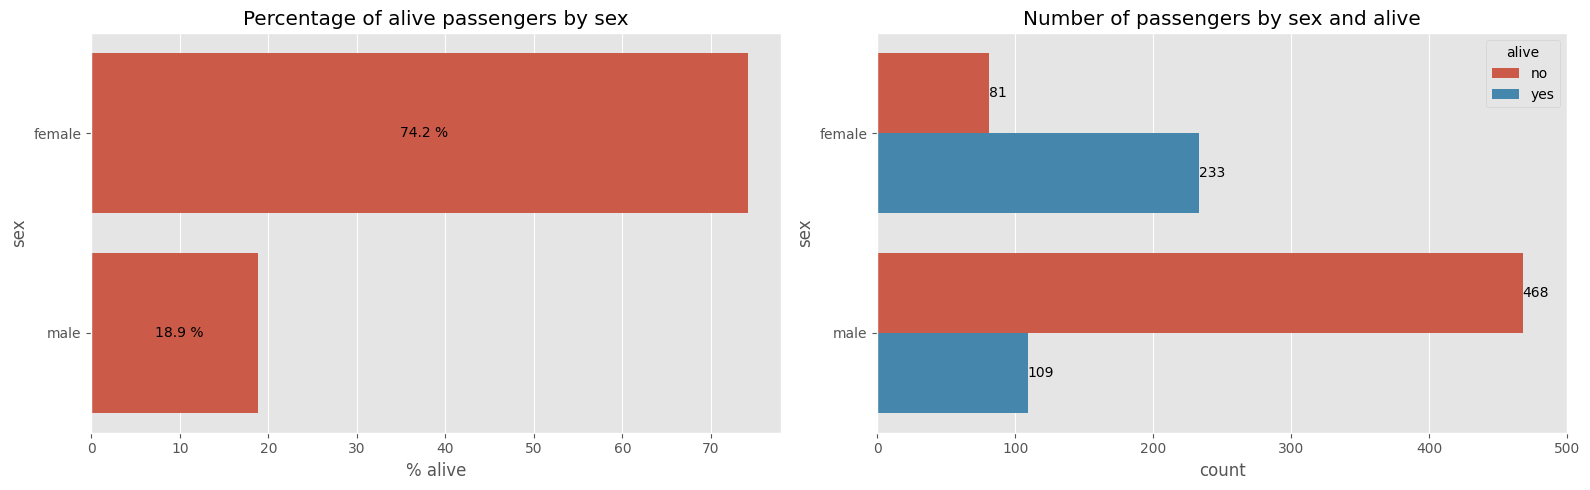

In [19]:
create_plot(data, 'sex', 500)

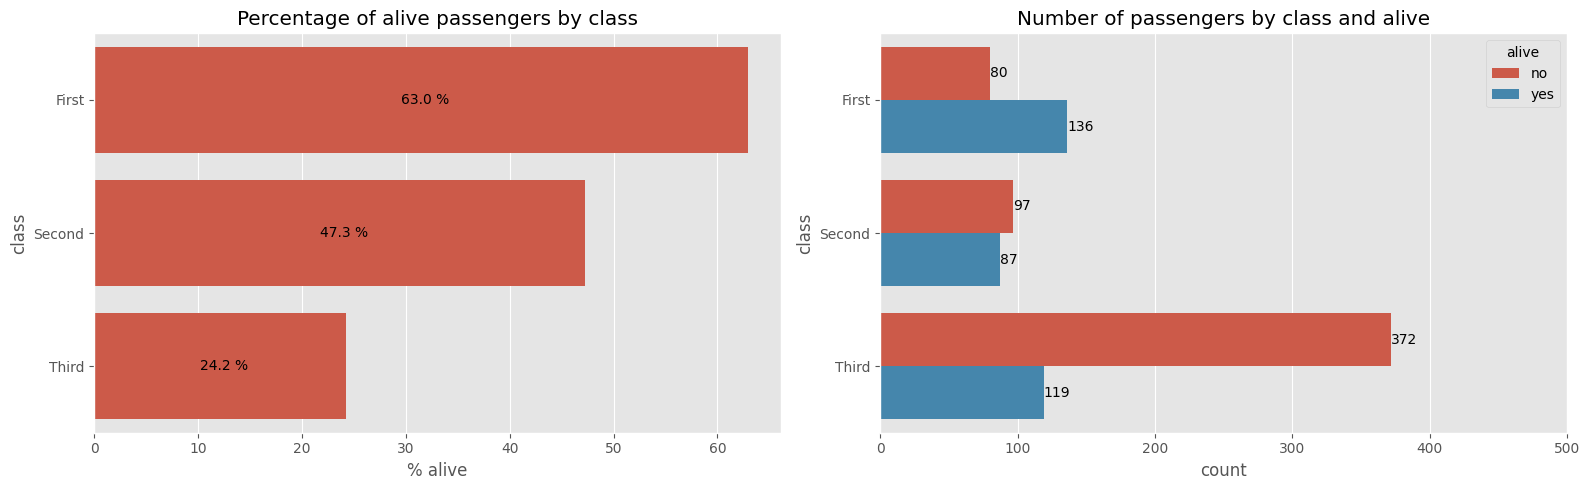

In [20]:
create_plot(data, 'class', 500)

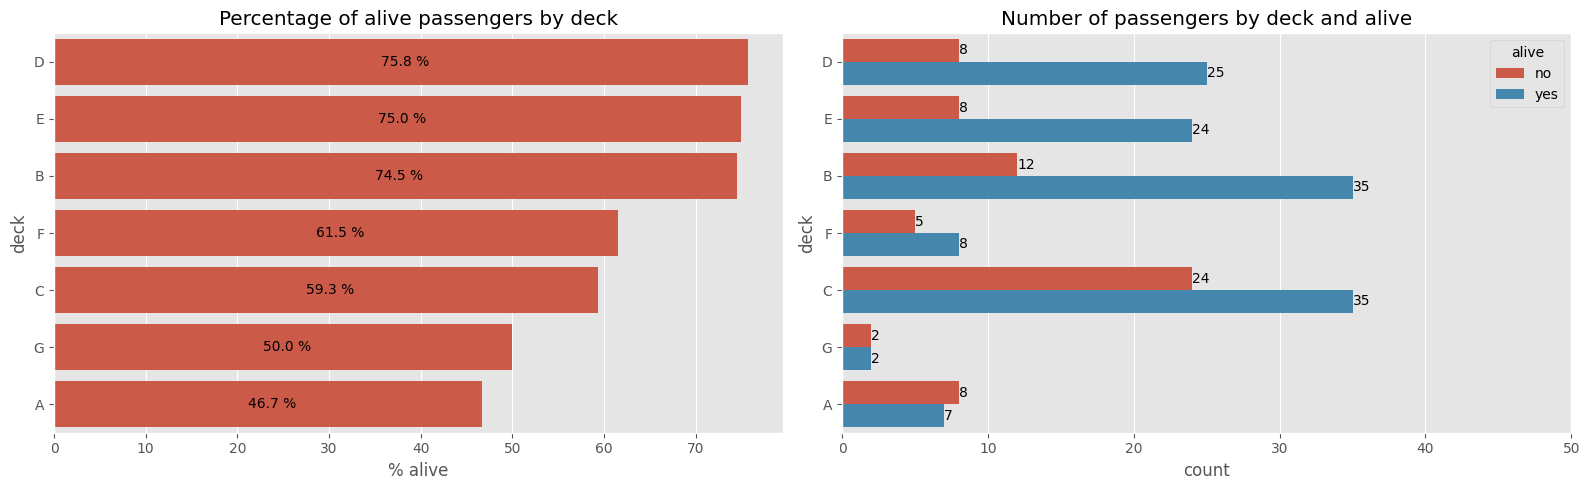

In [21]:
create_plot(data, 'deck', 50)

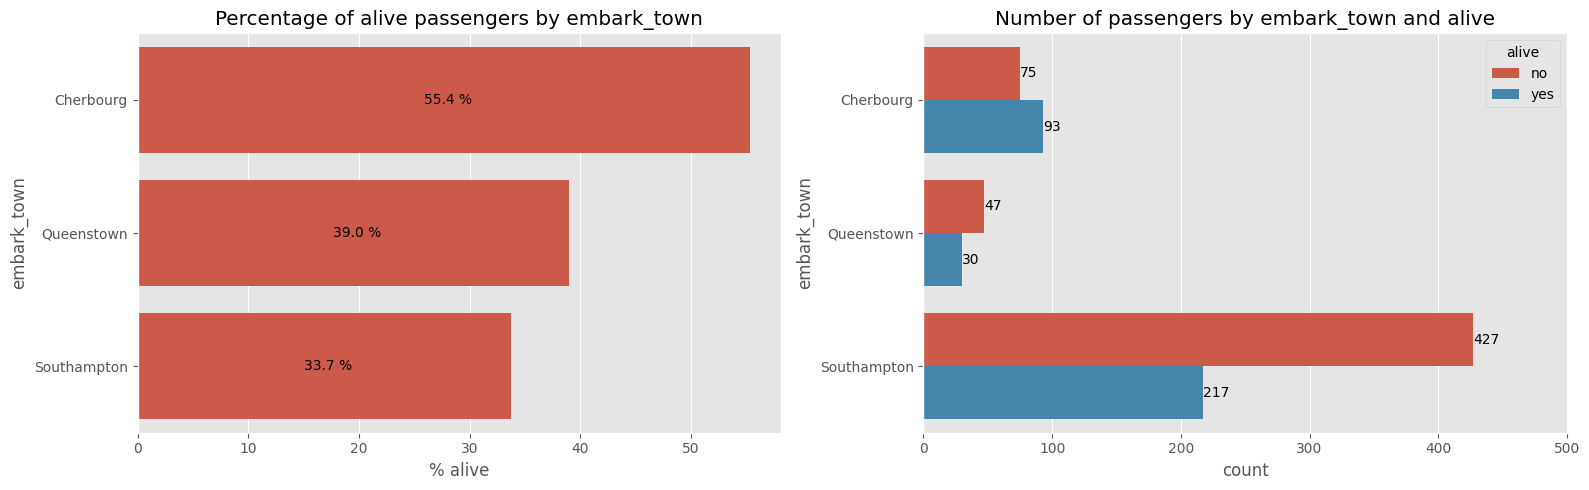

In [22]:
create_plot(data, 'embark_town', 500)

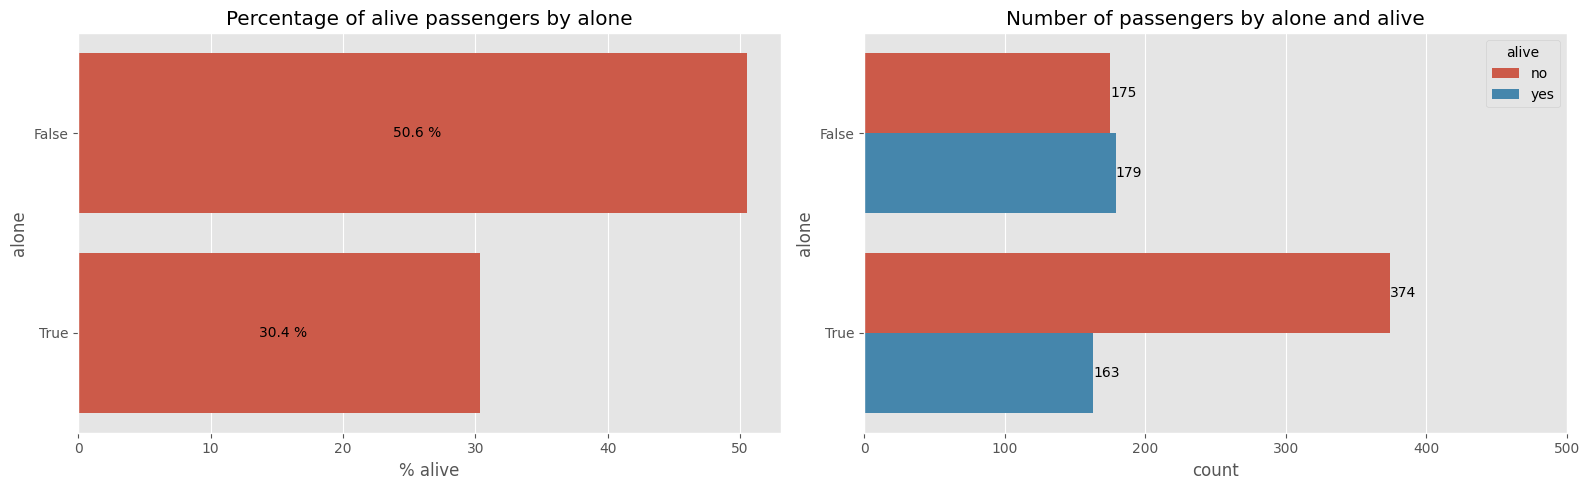

In [23]:
create_plot(data, 'alone', 500)

### **Data Preprocessing**

#### `Removed Unused Columns`

In [24]:
data.drop(columns='deck', inplace=True)

#### `Duplicates`

In [25]:
print(f"Number of duplicated data: {data[data.duplicated()].shape}")
print(f'Percentage of {len(data[data.duplicated()])/len(data)*100:.2f}%')

Number of duplicated data: (111, 8)
Percentage of 12.46%


Handling duplicated data

In [26]:
data.drop_duplicates(keep='last', inplace=True, ignore_index=True)

#### `Missing Values`

In [27]:
pd.DataFrame({'Missing values': [data[col].isna().sum() for col in data.columns]}, index=data.columns.values)

,Missing values
sex,0
age,104
parch,0
fare,0
class,0
embark_town,2
alive,0
alone,0


There are missing values ​​in the age and embark_town columns.

#### `Imbalance Data`

In [28]:
# Check the class distribution
from collections import Counter

print("Class distribution:", Counter(data['alive']))

Class distribution: Counter({'no': 458, 'yes': 322})


In [29]:
data['alive'].value_counts(normalize=True)

,proportion
alive,
no,0.587179
yes,0.412821


The data can still be categorized as balanced.

#### `Outliers`

In [30]:
def calculate_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_data = []

numerical = [var for var in data.columns if data[var].dtypes != 'object']

for column in numerical:
    outlier_result, lower_bound, upper_bound = calculate_outliers(data, column)
    total_outlier = len(outlier_result)
    outlier_percentage = round(total_outlier / len(data[column]) * 100, 2)
    outlier_data.append([column, total_outlier, outlier_percentage, lower_bound, upper_bound])

outlier_df = pd.DataFrame(outlier_data, columns=["Column", "Total Outliers", "Percentage (%)", "Lower Bound", "Upper Bound"])
outlier_df

,Column,Total Outliers,Percentage (%),Lower Bound,Upper Bound
0,age,7,0.90,-8.5000,67.5000
1,parch,15,1.92,-1.5000,2.5000
2,fare,97,12.44,-31.4375,73.8625


There are outliers in the numerical column with percentages ranging from 0% to 12.44%. We will examine the proportion of targets in these outliers.

In [31]:
proportion = []
indeces = []

for i, row in outlier_df.iterrows():
    outlier = data[(data[row['Column']] < row['Lower Bound']) | (data[row['Column']] > row['Upper Bound'])]
    percentages = (outlier['alive'].value_counts(normalize=True)*100).values
    proportion.append(percentages)
    indeces.append(row['Column'])

pd.DataFrame(proportion, columns=['Not Alive', 'Alive'], index=indeces)

,Not Alive,Alive
age,85.714286,14.285714
parch,73.333333,26.666667
fare,76.288660,23.711340


We find that the outliers in the 'age', 'parch', and 'fare' columns have different proportions of 'Not Survived' and 'Survived' items in the 'survived' column compared to the rest of the data. Therefore, we will not remove these outliers because they contain information that impacts the target.

#### `Collinearity`

In [32]:
def calculate_vif(data):
    vif = pd.DataFrame()
    vif['Feature'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.dropna(), i) for i in range(len(data.columns))]

    return vif.sort_values('VIF', ascending=False)

We will carry out repeated testing until we obtain a VIF value < 10.

In [33]:
vif_df = calculate_vif(data[numerical])
dropped_columns = []

for i in range(len(vif_df)):
    if vif_df.iloc[0, -1] < 10:
        break
    else:
        dropped_columns.append(vif_df.iloc[0, 0])
        vif_df = calculate_vif(data[numerical].drop(columns=dropped_columns))

In [34]:
vif_df

,Feature,VIF
2,fare,1.507939
0,age,1.429043
1,parch,1.224391


In [35]:
dropped_columns

[]

There is no multicollinearity

#### `Cardinality`

In [36]:
categorical = [var for var in data.columns if data[var].dtypes == 'object']

In [37]:
# creating a function to check cardinality
def check_cardinality(data):
    for feature in categorical:
        cardinality = len(data[feature].unique())
        print(f"Cardinality of {feature}: {cardinality}")

        if cardinality > 10:
            print(f"Warning: High cardinality in {feature}.")

check_cardinality(data)

Cardinality of sex: 2
Cardinality of class: 3
Cardinality of embark_town: 4
Cardinality of alive: 2
Cardinality of alone: 2


#### `Change Target Value`

Let's first change the values ​​in the `alive` column from 'yes' and 'no' to 1 and 0. Since our primary focus is survival, then:

Target:

1: Survive (`alive` == 'yes')

0: Die (`alive` == 'no')

In [38]:
data['alive'] = np.where(data['alive']=='yes',1,0)
data['alive'].unique()

array([0, 1])

#### `Feature Engineering`

**Handling Missing Values**

We will handle missing values ​​as follows:

1. Fill in the missing value for 'age' using the simple input median.
2. Fill in the missing value for 'embark town' using the simple input modus.

**Encoding**

Now let's encode our categorical features.
Here's what we'll do:

1. Convert the features/columns `sex, embark_town,` and `alone` using One Hot Encoding, as these features are not ordered/ordinal and have a small number of unique data points.

**Scaling**

We will use the Robust Scaler because our data contains outliers, and the Robust Scaler will not be affected by outliers. We can re-adjust the scaler later to find the best scaler.

### **Modeling**

#### `Define Features (X) and Target (y)`

In [39]:
# feature
X = data.drop(columns='alive')

# target
y = data['alive']

#### `Data Splitting`

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020, stratify=y
)

#### `Pipeline`

| Technique | Action |
| ----------------------------- | ----------- |
| Simple Imputer | Fills missing values ​​in the `embark_town` column with the most_frequent strategy and in the `age` column with the median strategy|
| One Hot Encoding | Transforms the `sex, alone, and embark_town` columns with the number of unique values ​​<= 10 |
| Ordinal Encoding | Transforms the `class` column with an order |
| Robust Scaling | Scales each feature using a robust scaler |

In [41]:
# Simple Imputer + Onehot Encoder untuk 'embark_town'
impute_mode_onehot = Pipeline([
    ('impute_mode', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

# Mapping Ordinal Encoder untuk 'class'
ordinal_mapping = [{'col':'class', 'mapping':{None: 0, 'First':3, 'Second':2, 'Third':1}}]

# Column Transformer
transformer= ColumnTransformer([
    ('impute_mode_onehot', impute_mode_onehot, ['embark_town']),
    ('onehot', OneHotEncoder(), ['sex', 'alone']),
    ('ordinal', OrdinalEncoder(cols=['class'], mapping=ordinal_mapping),['class']),
    ('impute_median', SimpleImputer(strategy='median'), ['age'])
], remainder='passthrough')

In [42]:
# Scaling
scaler = RobustScaler()

#### `Model Selection`

In [43]:
# Define the models
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=3)
dtree = DecisionTreeClassifier(max_depth=3)

In [44]:
# Model Selection
models = [logreg, knn, dtree]

accuracy_mean = []
accuracy_std = []
all_accuracy = []
model_name = []

# Find the best model based on the highest mean accuracy score and the lowest std
for algorithm in models:

    skfold = StratifiedKFold(n_splits = 5)

    model_pipe = Pipeline([
      ('preprocessing', transformer),
      ('scaler', scaler),
      ('model', algorithm)])

    model_cv = cross_val_score(
        model_pipe, # models already entered into the pipeline
        X_train, # data before preprocessing
        y_train,
        cv = skfold,
        scoring = 'accuracy'
      )

    accuracy_mean.append(model_cv.mean())
    accuracy_std.append(model_cv.std())
    all_accuracy.append(model_cv.round(4))
    model_name.append(algorithm.__class__.__name__)

In [45]:
# Comparison of accuracy scores for each algorithm
pd.DataFrame({
    'model': model_name,
    'mean': accuracy_mean,
    'std': accuracy_std,
    'all_score' : all_accuracy
})

,model,mean,std,all_score
0,LogisticRegression,0.761252,0.036768,"[0.776, 0.784, 0.776, 0.688, 0.7823]"
1,KNeighborsClassifier,0.722813,0.024533,"[0.704, 0.728, 0.736, 0.688, 0.7581]"
2,DecisionTreeClassifier,0.762890,0.051977,"[0.76, 0.8, 0.784, 0.664, 0.8065]"


*Predict Benchmark Model to Test Set*

In [46]:
list_accuracy_score = []

# Find the best model based on the largest f1 score and the smallest std
for algoritma in models :

    model_pipe=Pipeline([
        ('preprocess', transformer),
        ('scaler', scaler),
        ('model', algoritma)
    ])

    # fitting
    model_pipe.fit(X_train, y_train)

    # predict
    y_pred = model_pipe.predict(X_test)

    # evaluate
    score = accuracy_score(y_test, y_pred)
    list_accuracy_score.append(score)

In [47]:
# Performance comparison between models
pd.DataFrame({
    'model': model_name,
    'accuracy (test_set)': list_accuracy_score
})

,model,accuracy (test_set)
0,LogisticRegression,0.807692
1,KNeighborsClassifier,0.743590
2,DecisionTreeClassifier,0.788462


**Insight**

- Among the three models, the Decision Tree model had the highest average accuracy score on the train set, with a score of 76.28%. The Logistic Regression model also had the highest accuracy score on the test set.
- However, in terms of stability, the KNN model was the most stable due to its smallest standard deviation.
- Therefore, the KNN model was selected as the best model for the Titanic case.

#### `Hyperparameter Tuning`

In [48]:
# hyperparameters to be filled in the model (knn)
param_grid = {
    'model__metric': ['minkowski','euclidean'],
    'model__weights': ['uniform', 'distance'],
    'model__n_neighbors':range(3,30,2),
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), None]
}

In [49]:
from sklearn.model_selection import RandomizedSearchCV

# model benchmark
knn = KNeighborsClassifier(n_neighbors=3)

# model in pipeline
knn_pipeline = Pipeline([
    ('preprocess', transformer),
    ('scaler', scaler),
    ('model', knn)
])

skfold = StratifiedKFold(n_splits = 5)

# Grid search
tuned_model = RandomizedSearchCV(
    estimator = knn_pipeline,                   # model to tune
    param_distributions = param_grid,           # hyperparam space
    cv = skfold,
    scoring = 'accuracy',                       # metric
    n_jobs= -1,
    n_iter=100,
    random_state=0
)

# fit tuned_model on train set
tuned_model.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('impute_mode_onehot',
                                                                               Pipeline(steps=[('impute_mode',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder())]),
                                                                               ['embark_town']),
                                                                              ('onehot',
                                                                               OneHotEncoder(),
                                                                               ['sex'...
                                                                               SimpleImputer(strategy='median'),
                                                                               ['age'])])),
                                             ('scaler', RobustScaler()),
                                             ('model',
                                              KNeighborsClassifier(n_neighbors=3))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__metric': ['minkowski',
                                                          'euclidean'],
                                        'model__n_neighbors': range(3, 30, 2),
                                        'model__weights': ['uniform',
                                                           'distance'],
                                        'scaler': [StandardScaler(),
                                                   MinMaxScaler(),
                                                   RobustScaler(), None]},
                   random_state=0, scoring='accuracy')

In [50]:
# Best score from grid_search
print(f'Accuracy on train set: {tuned_model.best_score_:.3f}')

# Hyperparameters for the best score from tuned_model
print(f'Best parameter: {tuned_model.best_params_}')

Accuracy on train set: 0.779
Best parameter: {'scaler': MinMaxScaler(), 'model__weights': 'uniform', 'model__n_neighbors': 27, 'model__metric': 'minkowski'}


In [51]:
pd.DataFrame(tuned_model.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,param_model__weights,param_model__n_neighbors,param_model__metric,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,0.029394,0.002947,0.020478,0.000205,MinMaxScaler(),uniform,27,minkowski,"{'scaler': MinMaxScaler(), 'model__weights': '...",0.776,0.808,0.792,0.688,0.830645,0.778929,0.048923,1
44,0.030977,0.003818,0.020490,0.000199,MinMaxScaler(),uniform,25,euclidean,"{'scaler': MinMaxScaler(), 'model__weights': '...",0.768,0.808,0.792,0.688,0.830645,0.777329,0.049123,2
72,0.028572,0.001563,0.020303,0.000164,MinMaxScaler(),uniform,25,minkowski,"{'scaler': MinMaxScaler(), 'model__weights': '...",0.768,0.808,0.792,0.688,0.830645,0.777329,0.049123,2
77,0.029106,0.000673,0.023471,0.002719,MinMaxScaler(),uniform,15,euclidean,"{'scaler': MinMaxScaler(), 'model__weights': '...",0.792,0.784,0.792,0.704,0.806452,0.775690,0.036570,4
2,0.049197,0.013632,0.033004,0.009535,MinMaxScaler(),uniform,17,euclidean,"{'scaler': MinMaxScaler(), 'model__weights': '...",0.784,0.760,0.808,0.712,0.798387,0.772477,0.034290,5


**Predict Tuned Model to Test Set**

In [52]:
tuned_model.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_mode_onehot',
                                                  Pipeline(steps=[('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['embark_town']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['sex', 'alone']),
                                                 ('ordinal',
                                                  OrdinalEncoder(cols=['class'],
                                                                 mapping=[{'col': 'class',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': None      0
First     3
Second    2
Third     1
dtype: int64}]),
                                                  ['class']),
                                                 ('impute_median',
                                                  SimpleImputer(strategy='median'),
                                                  ['age'])])),
                ('scaler', MinMaxScaler()),
                ('model', KNeighborsClassifier(n_neighbors=27))])

In [53]:
# Model after hyperparameter tuning
best_model = tuned_model.best_estimator_

# Fitting model
best_model.fit(X_train, y_train)

# Predict to test set
y_pred_best = best_model.predict(X_test)

# Evaluate accuracy score on test set
print(f'Accuracy pada test set: {accuracy_score(y_test, y_pred_best):.3f}')

Accuracy pada test set: 0.814


| Accuracy Score | Train Set | Test Set |
| --- | --- | --- |
| Before Tuning | 0.721 | 0.743 |
| After Tuning | 0.779 | 0.814 |

**Insight**

- The model selected for modeling this dataset is **K-Nearest Neighbors (KNN).
- Hyperparameter tuning **successfully improved** the KNN model's performance based on accuracy.
- The best hyperparameters based on RandomizedSearch are **{'scaler': MinMaxScaler(), 'model__weights': 'uniform', 'model__n_neighbors': 27, 'model__metric': 'minkowski'}**
- If you still want to improve this KNN model, you can try:
  - Reset the hyperparameter values.
  - Change the ML algorithm.
  - Feature Engineering.
  - Add hyperparameters.